# Advanced Pandas

## Learning Objectives

1. Learn about the difference between views and copies.
2. Improve performance with vectorization and parallelization.
3. Join and merge data frames together.
4. Plot data with pandas.

## Views vs. Copies

In pandas, a distinction that will probably trip everyone up at least once is that between **views** (looking at part of an existing object) and **copies** (making a new copy of an object in memory). This is a bit abstract, and even [the pandas docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy) state the following:

> ...it’s very hard to predict whether [an operation] will return a view or a copy.

I recommend reading the following section:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

It's relatively short and could save you some effort.

The main takeaway is that the most common warning you’ll encounter in Pandas is the `SettingWithCopyWarning`; Pandas raises it as a warning that you might not be doing what you think you’re doing or because the operation you are performing may behave unpredictably.

As an example, say the number of seats on this particular plane was recorded incorrectly. Instead of 55 seats it should actually be 60 seats.

In [1]:
import pandas as pd

planes = pd.read_csv("../data/planes.csv")

tailnum_of_interest = planes['tailnum'] == 'N10156'
planes[tailnum_of_interest]

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N10156,2004.0,Fixed wing multi engine,EMBRAER,EMB-145XR,2,55,NaN,Turbo-fan


Let's say we naively try to set the number of sets, by filtering and selecting this element in our data frame with the following bracket notation:

In [2]:
planes[tailnum_of_interest]['seats'] = 60

/var/folders/hj/62925_2n77x4wf_k3c_4xz_m24r948/T/ipykernel_26781/1344183120.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planes[tailnum_of_interest]['seats'] = 60


As you can see, we get a `SettingWithCopyWarning`. Was the data frame changed?

In [3]:
planes[tailnum_of_interest]['seats']

0    55
Name: seats, dtype: int64

Long story short, subsetting by index creates a copy:

In [4]:
planes[tailnum_of_interest]._is_view

False

So that when you go to set the "seats" column you're not operating on the original data.

**Note:** don't rely on `._is_view`; it is a private variable and as such could be removed at any time. I only use it here for illustrative purposes.

The way to avoid this is to never chain accessors when setting data. Instead, use a single accessor with `.loc`:

In [5]:
planes.loc[
    tailnum_of_interest,
    "seats"
] = 60

planes[tailnum_of_interest]['seats']

0    60
Name: seats, dtype: int64

See the linked documentation for more details.

**Optional Note:** If you check `planes.loc[tailnum_of_interest, "seats"]`, you'll see that it results in a copy as well, not a view. What gives? This comes down to the way assignment works in Python; pandas has overriden it such that, *when used as the left hand side of an assignment statement*, this `.loc` expression results in a view instead of a copy.

## Vectorization and Parallelization

Pandas is relatively well optimized, with performance critical portions written in the compiled language Cython. But there's room for improvement on occasion.

### Vectorization

Under the hood, a pandas data frame is a multidimensional array backed by the numerical library NumPy. Let's assume we have an expensive function we wish to apply to each row of a data frame. For illustration we'll use a simple sum of squares:

In [6]:
def sum_squares(x, y):
    # Assume this is a much larger function,
    # with complex, branching logic.
    return x**2 + y**2

We can easily use this function with pandas:

In [7]:
%%time
planes.apply(
    lambda row: sum_squares(
        row["seats"], row["engines"]
    ),
    axis=1
).head(5)

CPU times: user 39.1 ms, sys: 2.14 ms, total: 41.3 ms
Wall time: 39.9 ms


0     3604
1    33128
2    33128
3    33128
4     3029
dtype: int64

But we can eke some performance out by dipping down into NumPy:

In [8]:
import numpy as np

In [9]:
%%time
np_result = np.vectorize(sum_squares)(
    planes["seats"], planes["engines"]
)
np_result[:5]

CPU times: user 3.5 ms, sys: 459 µs, total: 3.96 ms
Wall time: 3.56 ms


array([ 3604, 33128, 33128, 33128,  3029])

The `vectorize()` function takes one function and converts it into a function that operates on NumPy arrays (or pandas series, which are a special case of NumPy arrays). In this case -- though this is a very silly example -- we get almost 10x the performance by using NumPy.

Although the result is a NumPy array rather than a pandas series, you can still assign it to a column as if it were a series:

In [10]:
planes["silly_col"] = np_result

Fastest of all is to simply apply arithmetic operators to the indivudal series:

In [11]:
%%time
(planes["seats"]**2 + planes["engines"]**2).head(5)

CPU times: user 578 µs, sys: 56 µs, total: 634 µs
Wall time: 612 µs


0     3604
1    33128
2    33128
3    33128
4     3029
dtype: int64

But this won't work for more complex logic.

In general, there are a ton of useful functions in NumPy that work as you'd expect on pandas series and data frames. If you need to do numerical processing or linear algebra I would encourage you to read a guide, such as such as [this one](https://towardsdatascience.com/the-ultimate-beginners-guide-to-numpy-f5a2f99aef54).

### Parallelization

Another way to speed up code is to use parallel processing. Pandas under the hood is single-threaded, but for some tasks we can split a series or data frame into parts and operate on multiple portions simultaneously.

I want you to get a sense for how this is possible, but if you don't follow all of the Python code here that's fine. Just be aware of the capability so you can research it further.

First, we'll import from the `multiprocessing` module built into Python. This allows us to distribute a function over a sequence of elements in parallel:

In [12]:
from multiprocessing import Pool

We need a function to apply. As above, this would ordinarily be a more complex function, but we'll keep it simple:

In [15]:
def sum_squares_df(df):
    df["silly_col"] = (
        df["seats"]**2 + 
        df["engines"]**2
    )
    return df

However, due to a quirk of how the Jupyter and the multiprocessing module combine, we need to import it from a file:

In [18]:
import sum_squares

This sets up a pool of workers for parallel processing:

In [19]:
cores = 4
pool = Pool(cores)

Now we need to split the data frame up into 4 portions, one ofr each core. For this we'll use the `array_split()` function from NumPy, which does exactly what it says, in this case returning a list of 4 data frames:

In [20]:
planes_split = np.array_split(planes, cores)

Then we distribute the function over each data frame chunk:

In [21]:
split_work = pool.map(
    sum_squares.sum_squares_df,
    planes_split
)

Finally, we can combine the results back into one data frame, using the `concat()` function:

In [22]:
df = pd.concat(split_work)

We'll also need to clean up after ourselves, because we've opened multiple processes:

In [24]:
pool.close()
pool.join()

Although this is cumbersome, we could convert it to a reusable function:

In [26]:
def parallel_apply(
    df, func, cores
):
    pool = Pool(cores)
    splits = np.array_split(df, cores)
    split_work = pool.map(
        func, splits
    )
    df = pd.concat(split_work)
    pool.close()
    pool.join()
    
    return df

Something to note here is how much extra work we're doing to apply a function in parallel:

* Split the data frame into N copies
* Fork 4 new Python processes
* Run the function N times
* Concatenate the results back into one data frame
* Clean up

In other words: you should only do this if the code you're parallelizing is sufficiently time-intensive to make it worthwhile. Otherwise you could easily end up taking more time than you would if you'd remained single-threaded.

**Note:** In general, if you have a substantial amount of data and wish to leverage multiple cores or CPUs, you might be better served investigating a library that is built from the ground up to allow for distributed processing. Dask and PySpark are two possible alternatives in this space.

## Joining Data Frames

It's quite common to have mulitple data frames that need to be joined together. Consider the example of one "fact" table and multiple "dimension" tables, all stored separately:

In [27]:
fact = (
    pd.DataFrame({
        'dim_id': [1, 2, 3], 
        'val_x': ['x1', 'x2', 'x3']
    })
)
dim = (
    pd.DataFrame({
        'dim_id': [1, 2, 4], 
        'val_y': ['y1', 'y2', 'y4']
    })
)

We have several different options:

### Inner Join

An inner join matches pairs of observations whenever their keys are equal. We can do an inner join with the `merge` method:

In [40]:
inner = (
    fact.merge(
        dim,
        how="inner",
        on="dim_id"
    )
)
inner

,dim_id,val_x,val_y
0,1,x1,y1
1,2,x2,y2


Notice that the non-matching `dim_id`s are not represented here.

### Outer Join

An inner join keeps observations that appear in both tables. However, we often want to retain all observations in at least one of the tables. Consequently, we can apply various outer joins to retain observations that appear in at least one of the tables. There are three main types of outer joins:

* A left join keeps all observations in x.
* A right join keeps all observations in y.
* A full join keeps all observations in x and y.

#### Left Outer Join

With a left join we retain all observations from `fact`, and we add columns `dim`. Rows in `fact` where there is no matching key value in `dim` will have `NaN` values in the new columns. We can use a left (outer) join by specifying `how="left"`:

In [33]:
left = (
    fact.merge(
        dim,
        how="left",
        on="dim_id"
    )
)
left

,dim_id,val_x,val_y
0,1,x1,y1
1,2,x2,y2
2,3,x3,NaN


#### Right Outer Join

A right join is just a flipped left join where we retain all observations from `dim`, and we add columns from `fact`. Similar to a left join, rows in `dim` where there is no matching key value in `fact` will have NaN values in the new columns:

In [34]:
right = (
    fact.merge(
        dim,
        how="right",
        on="dim_id"
    )
)
right

,dim_id,val_x,val_y
0,1,x1,y1
1,2,x2,y2
2,4,NaN,y4


#### Full Outer Join

We can also perform a full outer join where we keep all observations in `fact` and `dim`. This join will match observations where the key variable(s) have matching information in both tables and then fill in non-matching values as NaN.

In [35]:
outer = (
    fact.merge(
        dim,
        how="outer",
        on="dim_id"
    )
)
outer

,dim_id,val_x,val_y
0,1,x1,y1
1,2,x2,y2
2,3,x3,NaN
3,4,NaN,y4


### Differing Keys

In the above cases `fact` and `dim` have been joined on the same column name. If you wish to join on columns that are named differently, you can do so with `left_on` and `right_on`:

In [38]:
fact_renamed = (
    fact.rename(
        columns={"dim_id": "fact_id"}
    )
)

merge_different_cols = (
    fact_renamed.merge(
        dim,
        how="inner",
        left_on="fact_id",
        right_on="dim_id"
    )
)
merge_different_cols

,fact_id,val_x,dim_id,val_y
0,1,x1,1,y1
1,2,x2,2,y2


As you can see, this will retain all joining columns.

### Multiple Keys

If you wish to join on multiple columns at once, simply pass a list to the `on` parameter(s):

In [39]:
# `assign()` creates a new column and
# returns a new data frame with that column:
fact_new_col = fact.assign(
    dim_id2=[1, 2, 3]
)
dim_new_col = dim.assign(
    dim_id2=[1, 2, 3]
)

fact_new_col.merge(
    dim_new_col,
    how="inner",
    on=["dim_id", "dim_id2"]
)

,dim_id,val_x,dim_id2,val_y
0,1,x1,1,y1
1,2,x2,2,y2


### `join()` vs `merge()`

Finally, you might encounter a second way to join two data frames: with the (appropriately named) `join()` method. This differs from `merge()` in that it requires you to join on the *index* rather than on one or more named columns:

In [41]:
fact_index = fact.set_index("dim_id")
dim_index = dim.set_index("dim_id")

# Remember, these new data frames are now
# indexed by "dim_id" rather than row
# number:
fact_index

,val_x
dim_id,
1,x1
2,x2
3,x3


In [43]:
inner_join = (
    fact_index
    .join(
        # no "on" argument
        dim_index,
        how="inner"
    )
)

inner_join

,val_x,val_y
dim_id,,
1,x1,y1
2,x2,y2


There is essentially no difference between `join()` and `merge()`: they perform equivalently in most cases and offer the same kinds of join. It's just a question of whether you're joining on the index or columns.

## Plotting in Pandas

The Python visualization ecosystem is extensive. You'll come across various libraries such as Matplotlib, Seaborn, Plotly and others. (See the [PyViz](https://pyviz.org/index.html) website for more information on plotting capabilities in Python.)

However, since we are focusing on pandas here, we'll stick with the plotting libraries that are native to that library (which use Matplotlib as a backend).

Fair warning, as we don't have much time this will be a pretty whirlwind tour.

For this we'll use a sample of the Complete Journey data provided externally by 84.51:

In [58]:
sales = pd.read_csv("../data/cj_sample.csv")

# We need to convert a string to a Timestamp
# with `to_datetime()`:
sales["transaction_timestamp"] = (
    pd.to_datetime(
        sales["transaction_timestamp"]
    )
)

### Plotting a Series

We can visualize the distribution of a `Series` with a histogram:

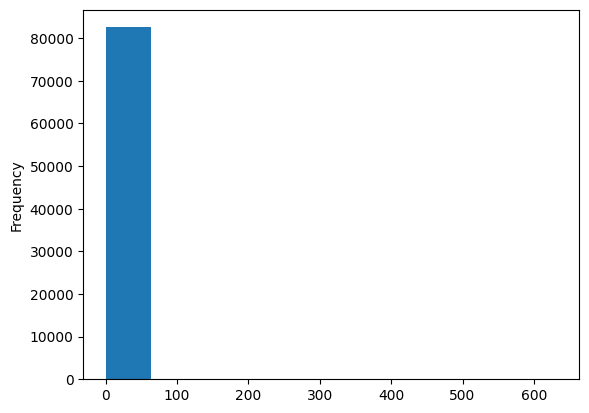

In [86]:
sales["sales_value"].plot.hist();

It's highly skewed. To get a more illustrative plot we can take the log:

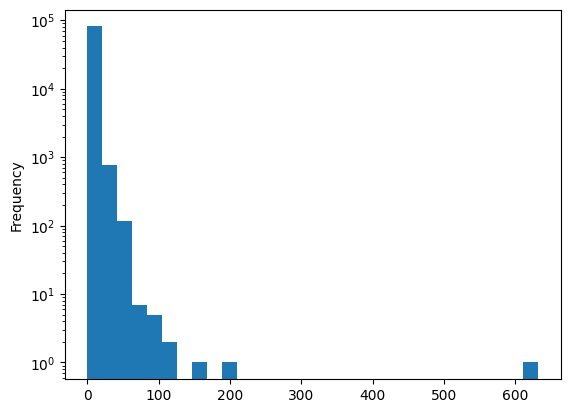

In [85]:
sales[
    sales["sales_value"] > 0
]["sales_value"].plot.hist(
    log=True, bins=30
);

We can also view a line plot over time, using the "transaction_timestamp" column. Pandas is quite good at dealing with dates and times, though in this case we need to set the time column to be the index:

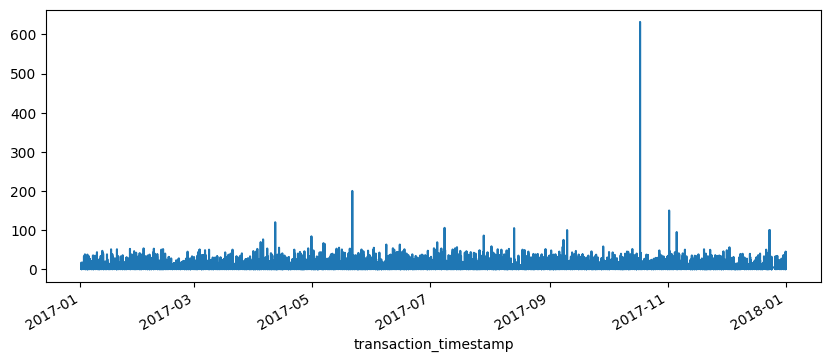

In [98]:
sales_indexed = (
    sales.set_index("transaction_timestamp")
    ["sales_value"]
)

(sales_indexed
 .plot.line(figsize=(10,4)));

That's not a particularly engaging plot. Fortunately, since we have a datetime index we can use `resample()` to group by the day and take the sum:

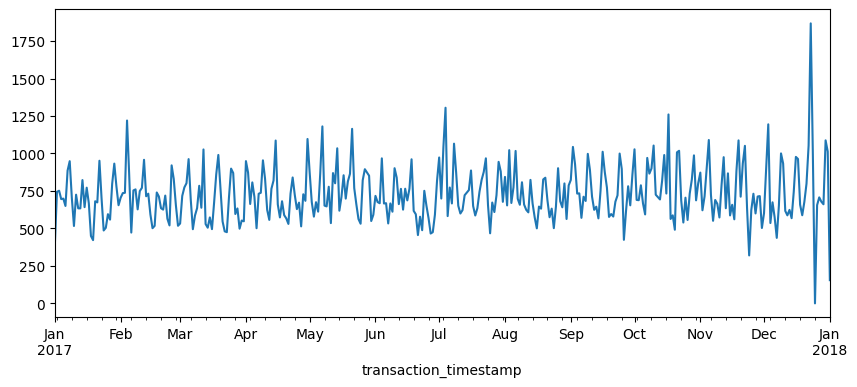

In [83]:
(
    sales_indexed
    .resample('D')
    .sum()
    .plot.line(figsize=(10,4))
);

We can even be reasonably fancy here. Let's say we wanted a plot of sales by day:

In [99]:
day_order = [
    'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday',
    'Sunday'
]

total_sales_by_weekday = (
    sales_indexed
    .resample('D')
    .sum()
    .rename(lambda idx: idx.day_name())
    .groupby('transaction_timestamp')
    .quantile([.25, .5, .75])
    .unstack()
    .reindex(day_order)
)

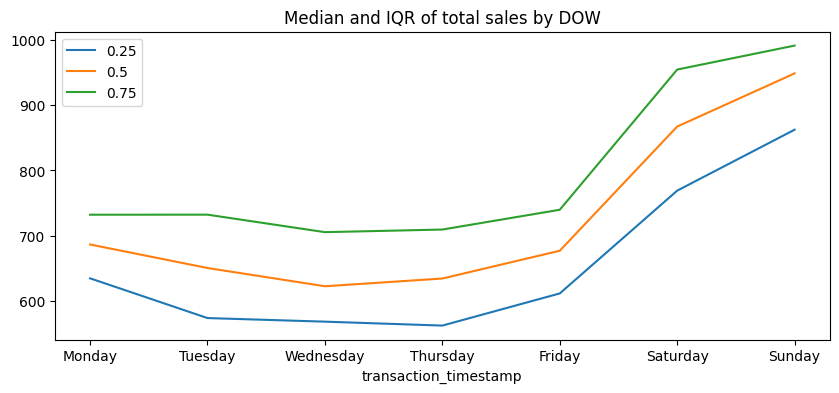

In [100]:
total_sales_by_weekday.plot.line(
    title='Median and IQR of total sales by DOW',
    figsize=(10,4)
);

Line by line, we:

1. Resample by day
2. Compute total sales for each day
3. Extract weekday from the index; to do this we use `rename()` which, when passed a function of one argument, will apply that function to the index
4. Group by the index, now weekday names
5. Compute quantiles for each group
6. Since this is multi-indexed Series, turn it into a data frame with `unstack()`; this takes the inner index (the quantile labels) and transposes them to be columns
7. Use `reindex()` to force the index into the customary daily ordering

For reference, the final data frame we use to plot looks like this:

In [76]:
(
    sales_indexed
    .resample('D')
    .sum()
    .rename(lambda idx: idx.day_name())
    .groupby('transaction_timestamp')
    .quantile([.25, .5, .75])
    .unstack()
    .reindex(day_order)
)

,0.25,0.50,0.75
transaction_timestamp,,,
Monday,634.9300,686.720,732.2500
Tuesday,574.1600,650.735,732.3175
Wednesday,568.6600,622.830,705.5575
Thursday,562.6550,634.630,709.5600
Friday,611.8275,677.125,739.8250
Saturday,769.0600,867.095,954.2750
Sunday,862.2900,948.430,990.9600


### Other Types of Plot

There are a number of different plots we can use here, including:

* box and whisker plots with `.plot.box()`
* kernel density plots with `.plot.kde()`
* bar plots with `.plot.bar()`
* horizontal bar plots with `.plot.barh()`
* pie charts with `.plot.pie()` (but please don't)

## Plotting a Data Frame

With the basics of plotting a `Series`, this can easily be extended to plotting with multiple columns of a data frame. For example, let's say we wanted to plot sales vs quantity sold across all transactions:

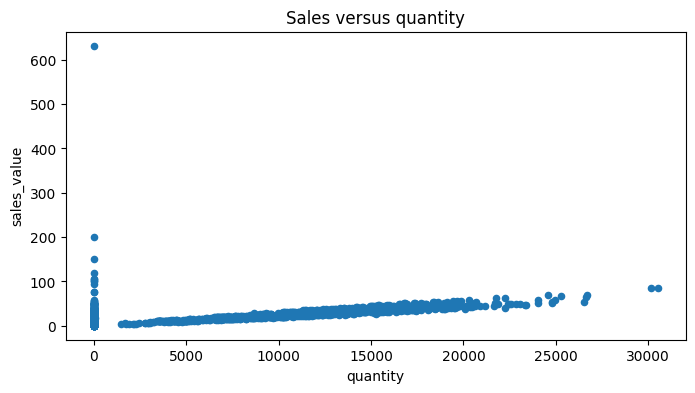

In [89]:
sales.plot.scatter(
    x='quantity', 
    y='sales_value', 
    title='Sales versus quantity', 
    figsize=(8,4)
);

We can use the same plotting methods with a data frame as we used for a series. For example, say we wanted to view the distribution of sales by department:

In [103]:
dept_sales = (
    sales.groupby("department", as_index=False)
    .agg({"sales_value": "sum"})
    .sort_values("sales_value", ascending=False)
    .head(5)
)

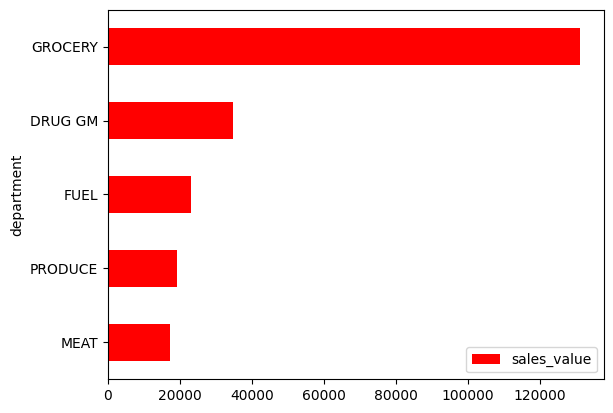

In [104]:
(dept_sales
 .sort_values('sales_value')
 .plot.barh(
      x='department', 
      y='sales_value', 
      color='red'
));

We can even plot multiple lines, in just the same manner as we plotted a series. Say we wanted to plot sales over time for various discount types:

In [96]:
total_daily_discounts = (
    sales[sales["department"] == "GROCERY"]
    .set_index('transaction_timestamp')
    .loc[:, ['retail_disc', 'coupon_disc', 'coupon_match_disc']]
    .resample('D')
    .sum()
)

total_daily_discounts.head()

,retail_disc,coupon_disc,coupon_match_disc
transaction_timestamp,,,
2017-01-01,50.70,0.0,0.0
2017-01-02,82.02,0.4,0.4
2017-01-03,68.34,1.0,0.0
2017-01-04,71.44,1.4,0.4
2017-01-05,56.66,0.0,0.0


If we apply `.plot.line()` to this data frame then by default it will plot each of the numeric variables on the same plot:

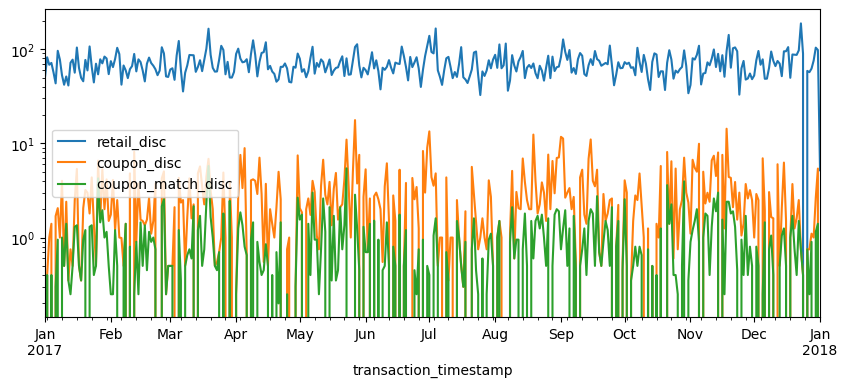

In [97]:
total_daily_discounts.plot.line(
    logy=True, figsize=(10, 4)
);

## Questions

Are there any questions before moving on?